# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import os

#### Model Parameters

In [31]:
LOOK_BACK = 90
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 16
EPOCHS=200
LEARN_RATE=0.0005
VALIDATION_SPLIT=0.1
NUMBER_NEURONS=128
PERIOD='5y'
NUMBER_OF_LAYERS=2;

#### Loading data from Yahoo

In [3]:
df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df.to_csv('stocks.csv')


In [4]:
#df = pd.read_csv('stocks.csv')

### EDA - Exploratory Data Analysis

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

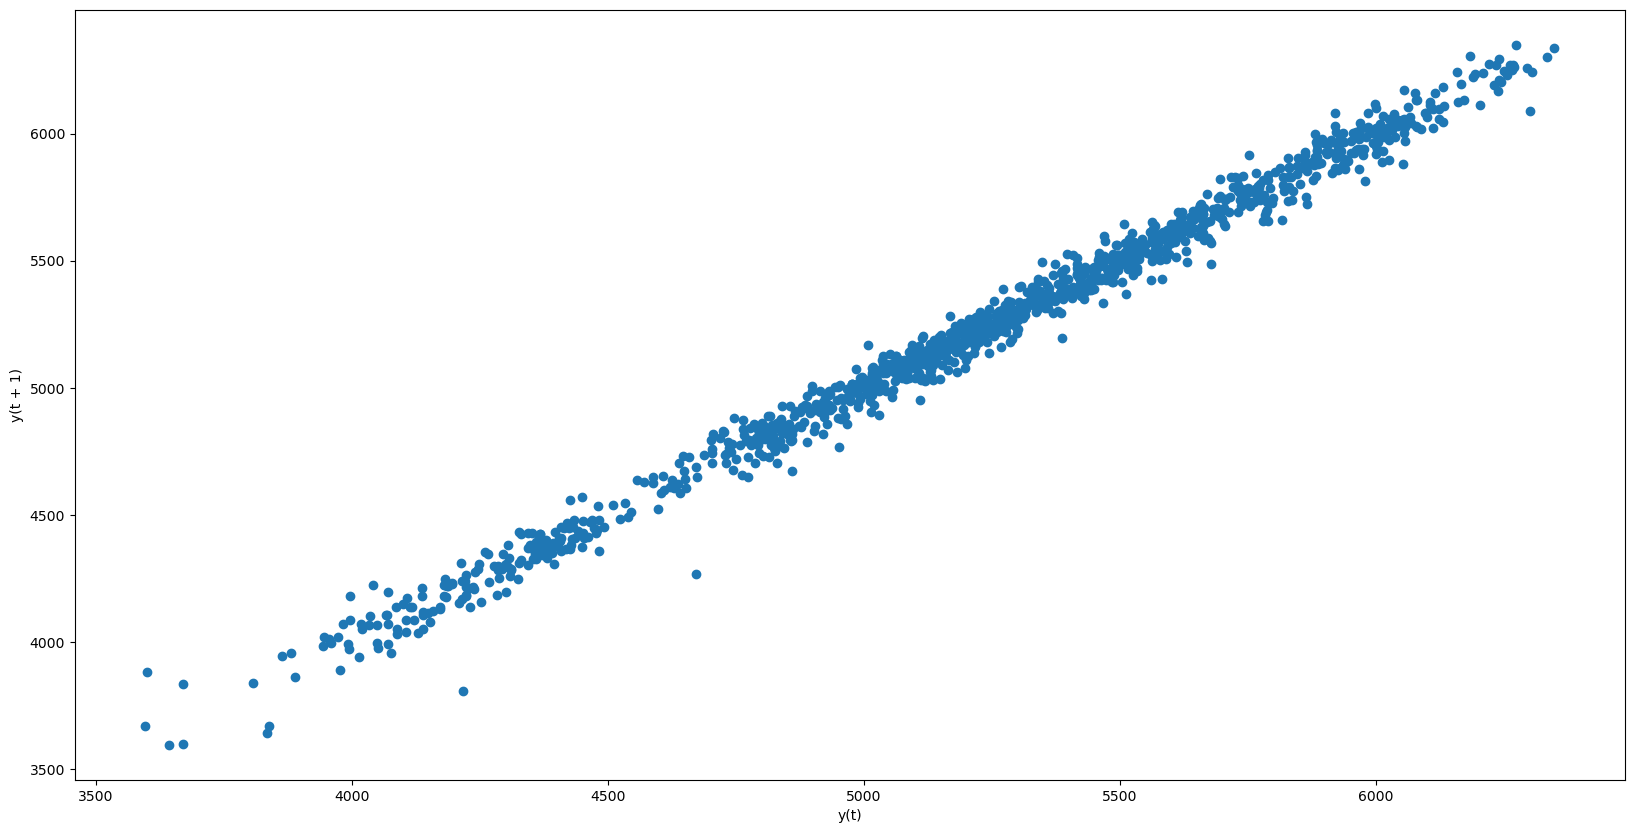

In [5]:
from pandas.plotting import lag_plot
lag_plot(df['Close'])

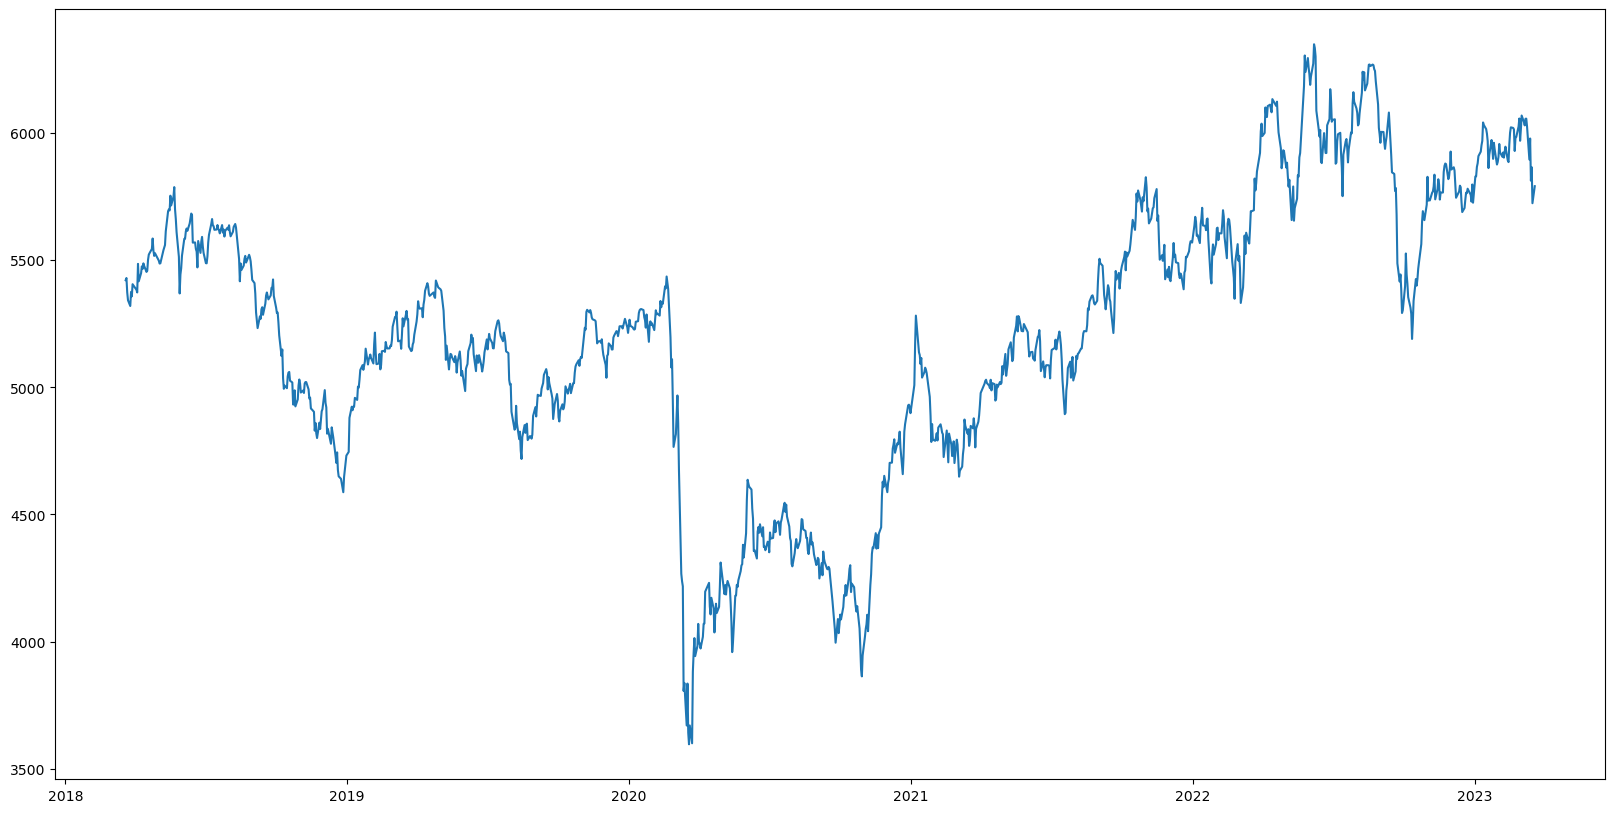

In [6]:
plt.plot(df['Close'])

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1272.000000,1272.000000,1272.000000,1272.000000,1.272000e+03,1272.0,1272.0
mean,5218.574354,5249.539092,5185.358439,5217.383323,8.137017e+07,0.0,0.0
std,544.795079,544.313987,545.391740,545.602531,4.396102e+07,0.0,0.0
min,3554.699951,3613.669922,3500.020020,3596.080078,0.000000e+00,0.0,0.0
25%,4924.752563,4950.377319,4893.439941,4921.622314,5.163125e+07,0.0,0.0
50%,5237.319824,5262.250000,5211.149902,5236.244873,6.856130e+07,0.0,0.0
75%,5613.199951,5640.265015,5586.130005,5614.182373,9.773775e+07,0.0,0.0
max,6362.879883,6370.779785,6314.640137,6349.209961,3.252189e+08,0.0,0.0


### Setting the Model

##### Data Preparation

In [8]:
#Dropping unwanted columns
def selectData(type='univariate') :
    if type=='univariate' :
        data = df.drop(columns=['Open', 'High', 'Low','Volume','Dividends','Stock Splits'])
    else :
        data = df.drop(columns=['Open', 'High', 'Low','Dividends','Stock Splits'])
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [9]:
# Divides Data into Train Data and Test Data
def divideData(data, size) : 
    train_data=data.values[0:size,:]
    test_data=data.values[size:,:]
    return train_data,test_data

In [10]:
# Scale Data between 0 and 1 
def scaleData(data,*scaler) :
    if len(scaler) == 1 :
        return scaler[0].fit_transform(data)
    else: 
        a1=scaler[0].fit_transform(data[:,0].reshape(-1,1))
        a2=scaler[1].fit_transform(data[:,1].reshape(-1,1))    
        scaled_data = np.array([a1,a2]).squeeze()
    return np.transpose(scaled_data)


In [11]:
def diffLogData (data) : 
    
    data = np.reshape(data,(1, data.size))
    
    return np.transpose(np.diff(np.log(data)))


In [12]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data, size) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x_train=[]

    for i in range(LOOK_BACK,size):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [13]:
def createBivTrainVector(data, size) :
    x0, x1 = [],[]
    for i in range(LOOK_BACK,size):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    return  np.reshape(x_data,(x_data.shape[1],x_data.shape[2],x_data.shape[0]))
   

In [14]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [15]:
#%% Creates a vectors with target data
from keras.utils import to_categorical
def createTargetClassVector(data, numCat=5) :
    data = data[LOOK_BACK:]
    percentiles = []
    y_data = []

    # Calculate Percentiles
    for i in range(0,numCat) :
            percentiles.append(np.percentile(data, (100/numCat)*i))
            
            
    # fill the vector with a classification number from 0 to [numCat]
    for i in range(0,len(data)):
        for j in reversed(range(0,numCat)) :
            if(data[i]>=percentiles[j]):
                y_data.append(j)
                data[i]=-1
                

    from keras.utils import to_categorical       
    #one hot encode the vector 
    return np.asarray(to_categorical(y_data, num_classes=len(np.unique(y_data))))
    


In [16]:
# CREATES a VECTOR FOR TEST WITH LENGTH = PERIODS_TO_PREDICT + LOOK_BACK
def selectTestData (data, size):
    test_data=data[size-LOOK_BACK:].values
    return test_data.reshape(-1,1)
    

In [17]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)

    #Reshaopes the vector for the predict function
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [18]:
def createBivTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x0,x1=[],[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    X_test=np.array([np.array(x0),np.array(x1)])
    return np.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))

#### LSTM Model

In [19]:
#%% Creates a LSTM Sequential model
def createLstmModel (data,outputs=1) : 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    try:
        numSources = data.shape[2]
    except:
        numSources = 1
    

    input_shape=(np.shape(data)[1],numSources)
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    if (outputs == 1) : 
        lstm_model.add(Dense(units=outputs))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
    elif (outputs > 1) : 
        lstm_model.add(Dense(units=outputs, activation = 'softmax'))
        
        lstm_model.compile(loss='categorical_crossentropy',
                   metrics=['accuracy'],
                   optimizer=Adam(learning_rate=LEARN_RATE)
                   )
    return lstm_model

In [20]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

### Running the model

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [103]:
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
x_train_data = createTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data)

In [104]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.66298354 0.66611101 0.6454763  ... 0.73532308 0.72533072 0.73341616]
 [0.66611101 0.6454763  0.63435064 ... 0.72533072 0.73341616 0.73794563]
 [0.6454763  0.63435064 0.62610913 ... 0.73341616 0.73794563 0.73506148]
 ...
 [0.87143007 0.85933109 0.87482251 ... 0.81110224 0.81135285 0.82480309]
 [0.85933109 0.87482251 0.87474252 ... 0.81135285 0.82480309 0.82996075]
 [0.87482251 0.87474252 0.86102359 ... 0.82480309 0.82996075 0.8402328 ]]

y data - target

[[0.73794563]
 [0.73506148]
 [0.74140706]
 ...
 [0.82996075]
 [0.8402328 ]
 [0.84659275]]


In [105]:
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler)
X_test = createTestVector(scaled_test_data)
lstm_model = createLstmModel(x_train_data)
trainLstmModel(lstm_model, x_train_data, y_train_data)

Epoch 1/100
128/128 [==============================] - 7s 38ms/step - loss: 0.0175 - val_loss: 0.0019
Epoch 2/100
128/128 [==============================] - 5s 41ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/100
128/128 [==============================] - 5s 38ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/100
128/128 [==============================] - 4s 33ms/step - loss: 0.0011 - val_loss: 9.6511e-04
Epoch 5/100
128/128 [==============================] - 4s 35ms/step - loss: 9.8645e-04 - val_loss: 9.5118e-04
Epoch 6/100
128/128 [==============================] - 4s 33ms/step - loss: 9.1346e-04 - val_loss: 7.9800e-04
Epoch 7/100
128/128 [==============================] - 4s 34ms/step - loss: 8.5943e-04 - val_loss: 7.7554e-04
Epoch 8/100
128/128 [==============================] - 4s 34ms/step - loss: 7.7887e-04 - val_loss: 8.0776e-04
Epoch 9/100
128/128 [==============================] - 4s 33ms/step - loss: 7.8347e-04 - val_loss: 8.3881e-04
Epoch 10/100
128/128 [================

KeyboardInterrupt: 

#### Bivariate Model

In addition to the univariate method (above) This model also considers the volume of trading during the [LOOK_BACK] days before, to estimate the value of the index. 

In [ ]:

global_data, size_train_data = selectData(type='bivariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values


scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


In [ ]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

In [ ]:

lstm_biv_model = createLstmModel(x_train_data)
trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Epoch 1/200
32/32 [==============================] - 5s 91ms/step - loss: 0.0764 - val_loss: 0.0717
Epoch 2/200
32/32 [==============================] - 2s 73ms/step - loss: 0.0317 - val_loss: 0.0991
Epoch 3/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0288 - val_loss: 0.0731
Epoch 4/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0321 - val_loss: 0.0454
Epoch 5/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0288 - val_loss: 0.0541
Epoch 6/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0266 - val_loss: 0.0619
Epoch 7/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0258 - val_loss: 0.0467
Epoch 8/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0245 - val_loss: 0.0673
Epoch 9/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0241 - val_loss: 0.0423
Epoch 10/200
32/32 [==============================] - 2s 72ms/step - loss: 0.0235 - val_loss: 0.0524

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [ ]:
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data, size_train_data)
x_train_data = x_train_data = x_train_data[:-1]
y_train_data = createTargetVector(scaled_train_data)
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)

In [ ]:
lstm_difflog_model = createLstmModel(x_train_data)
trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)                                


#### Classification Model (based on Diff(log) model)

In [32]:
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data, size_train_data)
x_train_data = x_train_data[:-1]
y_train_data = createTargetClassVector(scaled_train_data, numCat=3)

test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)


In [33]:
#Show how many observations are in each percentile

numCat=y_train_data.shape[1]
for i in range(0, numCat):
    print('percentile ' + str(i*int(100/numCat)) + ' = ' + str(np.count_nonzero(y_train_data[:,i] == 1)))


percentile 0 = 377
percentile 33 = 377
percentile 66 = 377


Epoch 1/200
64/64 [==============================] - 10s 99ms/step - loss: 1.0993 - accuracy: 0.3196 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 2/200
64/64 [==============================] - 5s 84ms/step - loss: 1.0991 - accuracy: 0.2960 - val_loss: 1.0984 - val_accuracy: 0.3509
Epoch 3/200
64/64 [==============================] - 5s 81ms/step - loss: 1.0990 - accuracy: 0.3255 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 4/200
64/64 [==============================] - 5s 78ms/step - loss: 1.0989 - accuracy: 0.3156 - val_loss: 1.0985 - val_accuracy: 0.3246
Epoch 5/200
64/64 [==============================] - 5s 78ms/step - loss: 1.0988 - accuracy: 0.3186 - val_loss: 1.0983 - val_accuracy: 0.3509
Epoch 6/200
64/64 [==============================] - 5s 79ms/step - loss: 1.0989 - accuracy: 0.3304 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 7/200
64/64 [==============================] - 5s 78ms/step - loss: 1.0988 - accuracy: 0.3353 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch

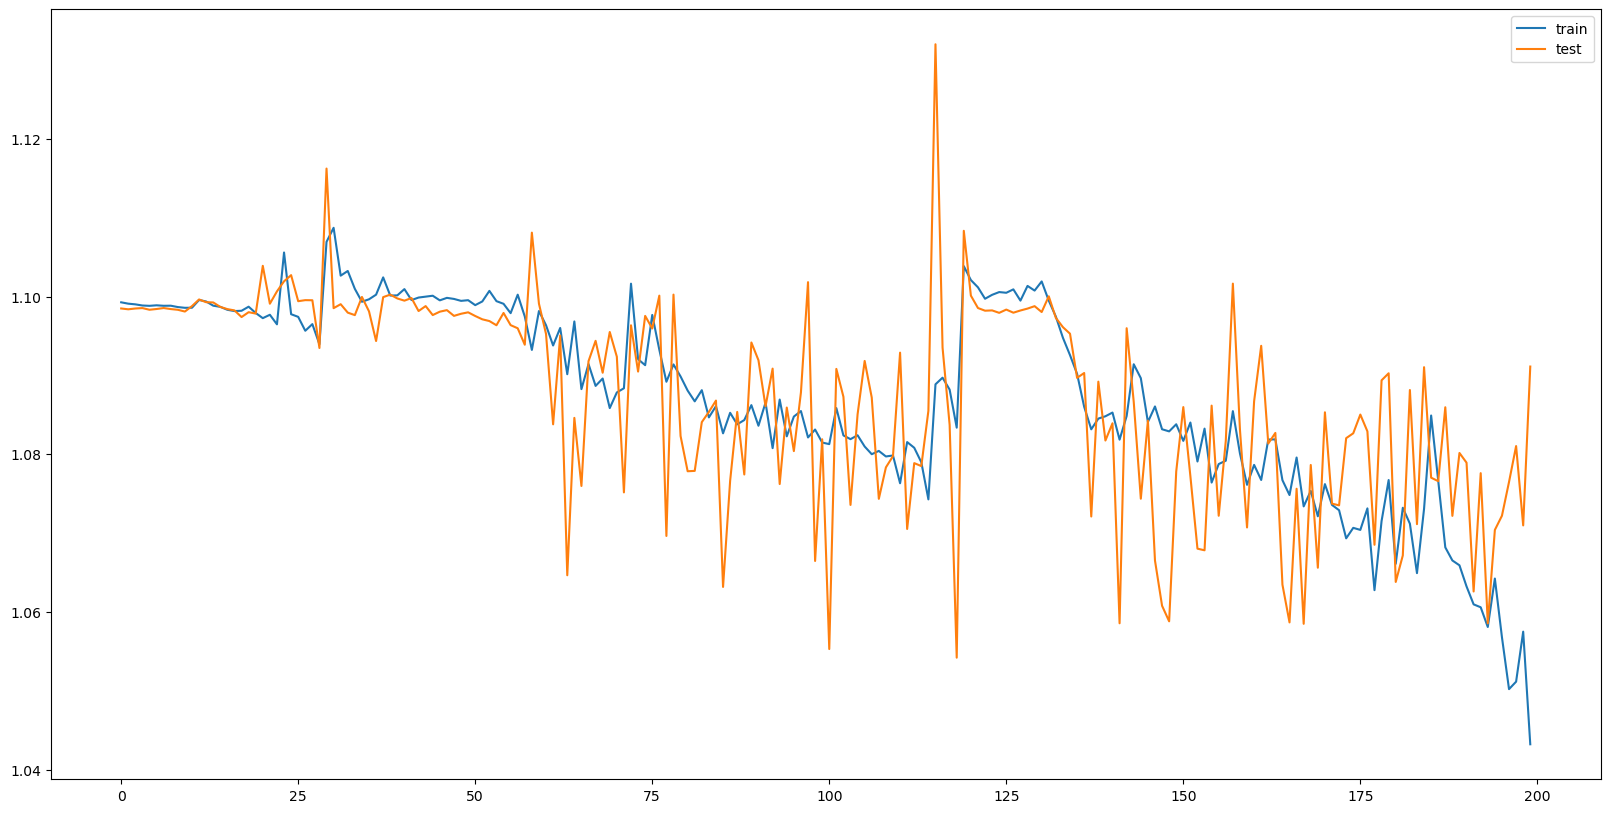

In [34]:
lstm_class_model = createLstmModel(x_train_data, y_train_data.shape[1])
history = trainLstmModel(lstm_class_model, x_train_data, y_train_data)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


## Prediction

##### Prediction Benchmark

In [128]:

#%% Day - Before Prediction function
day_before_price=global_data.iloc[size_train_data-1:].copy()
day_before_price_copy = day_before_price.copy()


for i in range(1,day_before_price.size): 
        day_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()

day_before_price=day_before_price.iloc[1:]

##### Evaluate Predictions:

In [131]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    


In [99]:
def testDayBeforeScore():
    testScore = np.sqrt(mean_squared_error(global_data.iloc[size_train_data:], day_before_price['Close']))
    print('==================================')
    print('Test Score Day before: %.2f RMSE' % (testScore))
    print('==================================')

#### Plotting the results

In [76]:
def fillDataForPlotting (): 
    #Setting Vectors for plotting
    train_data = global_data.iloc[:size_train_data]
    test_data = global_data.iloc[size_train_data:]
    test_data = test_data.assign(Predictions=predicted_stock_price)
    test_data = test_data.assign(Day_Before=day_before_price)
    return train_data,test_data

In [77]:
def plotAllHistory (train_data,test_data): 
    #Plotting all history
    plt.plot(global_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title('PSI-20 Prediction')
    plt.xlabel('Time')
    plt.ylabel('PSI-20 Index')
    plt.legend()
    plt.show()  

In [78]:
def plotPredictedPeriod (train_data,test_data):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title('PSI-20 Prediction')
    plt.xlabel('Time')
    plt.ylabel('PSI-20 Index')
    plt.legend()
    plt.show()  


In [79]:
def plotResults():
    train_data,test_data = fillDataForPlotting();
    plotAllHistory(train_data,test_data);
    plotPredictedPeriod(train_data,test_data);


### Running Predictions

##### Linear Model

In [70]:
#Linear model
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 0s 26ms/step


In [73]:
testPredictionsScore()
testDayBeforeScore()


Test Score: 57.43 RMSE
Test Score Day before: 55.59 RMSE


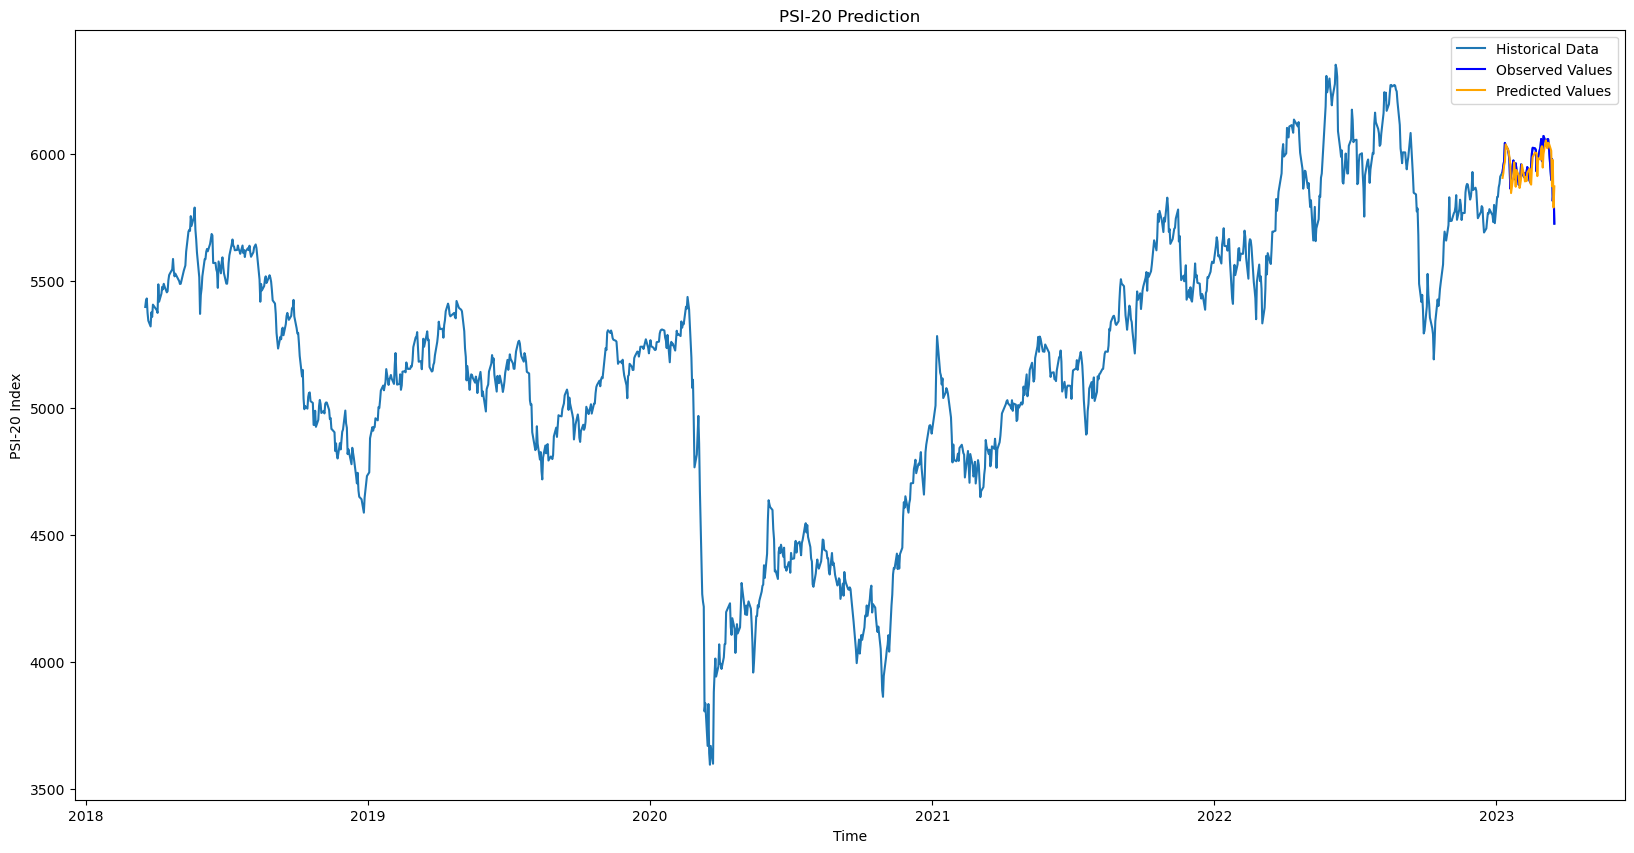

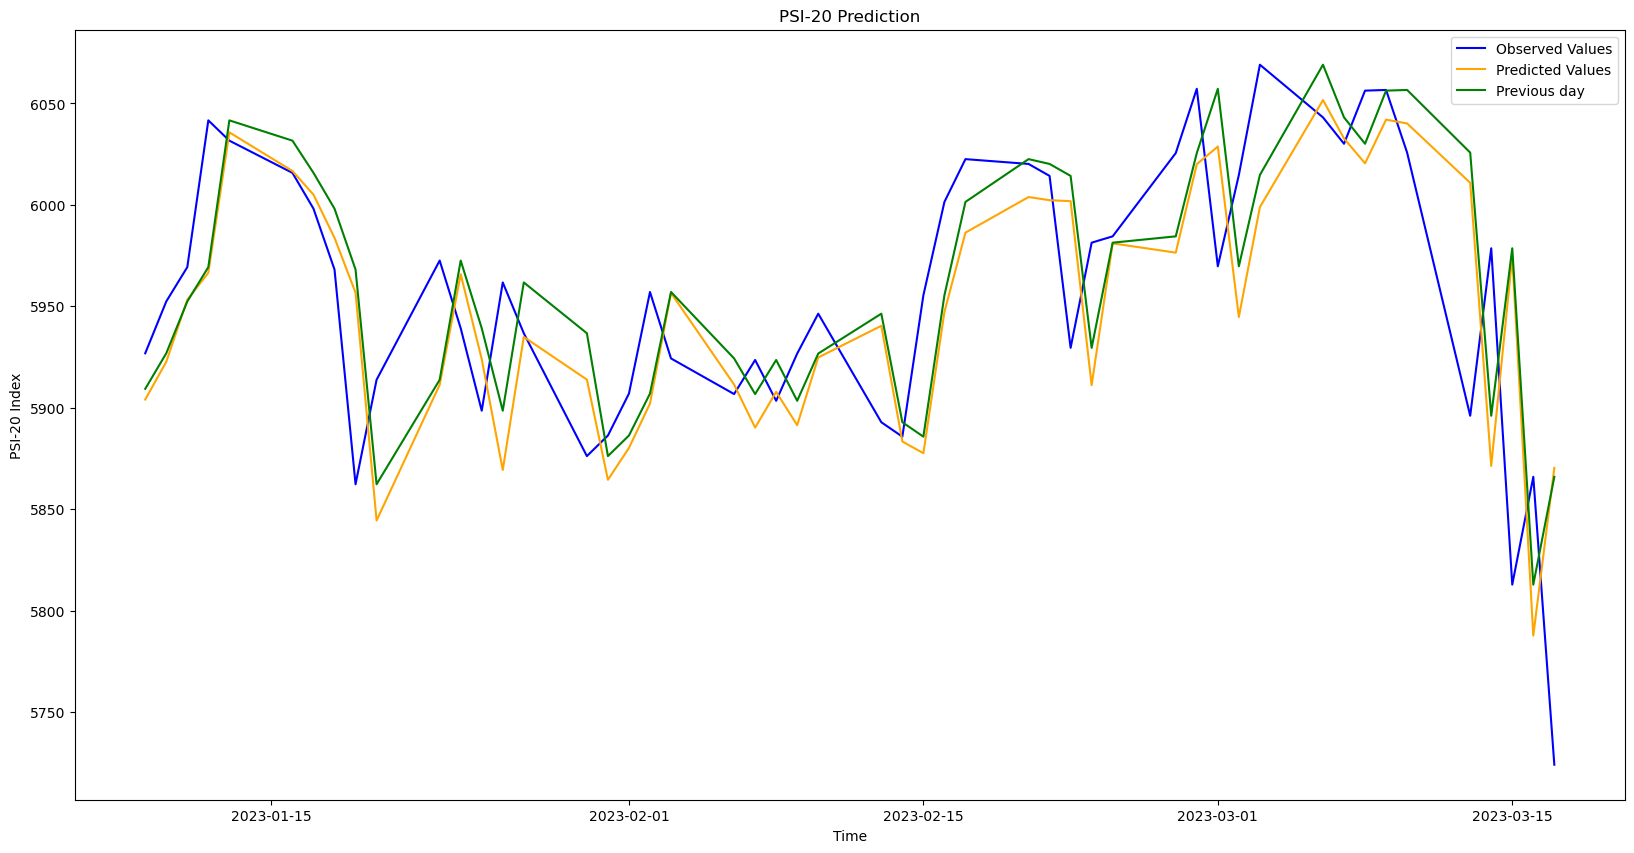

In [80]:
plotResults()

##### BivariateModel

In [87]:
#Bivariate model
predicted_stock_price=lstm_biv_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 1s 25ms/step


In [92]:
testPredictionsScore()


Test Score: 393.96 RMSE


In [ ]:
testDayBeforeScore()

##### DiffLog Model

In [105]:
#Difflog Model
predicted_stock_price=lstm_difflog_model.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [119]:
testPredictionsScore(scaled_test_data)
#testDayBeforeScore()

Test Score: 0.01 RMSE


##### Classification Model

In [38]:
#Category Model
predicted_stock_cat=lstm_class_model.predict(X_test)

2/2 [==============================] - 0s 29ms/step


In [42]:

predictions=np.argmax(predicted_stock_cat, axis=1)

In [43]:
print(predicted_stock_cat)
print(predictions)
##testPredictionsScore("categorical")


[[0.34561992 0.38190973 0.27247038]
 [0.35189024 0.378886   0.26922384]
 [0.3524927  0.38216949 0.26533774]
 [0.35494506 0.3820329  0.26302212]
 [0.35840577 0.3800251  0.26156917]
 [0.36434177 0.3769405  0.25871772]
 [0.36844417 0.37262157 0.25893426]
 [0.37805942 0.3591265  0.26281402]
 [0.37740156 0.3576253  0.26497313]
 [0.37149394 0.36352718 0.26497883]
 [0.37729725 0.35673618 0.2659665 ]
 [0.3737191  0.3490103  0.27727062]
 [0.37735564 0.33328786 0.28935653]
 [0.35504574 0.3370964  0.3078579 ]
 [0.2983994  0.38371956 0.317881  ]
 [0.2892108  0.3874146  0.32337442]
 [0.29310083 0.37451264 0.33238658]
 [0.28794524 0.38445812 0.32759678]
 [0.2950077  0.3847405  0.3202518 ]
 [0.30303985 0.37754267 0.31941757]
 [0.304422   0.35199693 0.34358102]
 [0.30884483 0.34469813 0.34645697]
 [0.30919427 0.35325447 0.3375513 ]
 [0.3118083  0.360966   0.3272256 ]
 [0.31938288 0.3618285  0.31878862]
 [0.3281679  0.36076766 0.31106448]
 [0.33233014 0.36438236 0.30328757]
 [0.346411   0.3691506  0.28

## Clear All

In [121]:
globals().clear

<function dict.clear>